In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import torchvision.transforms as T
import albumentations as A
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
from albumentations.pytorch import ToTensorV2
device = 'cuda:0'

In [30]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, images, masks, transform):
        self._images = images
        self._masks = masks
        self._transform = transform
  
    def __len__(self):
        return len(self._images)
  
    def __getitem__(self, index):
        image, mask = Image.open(self._images[index]), Image.open(self._masks[index]).convert('L')
        augmented = self._transform(image=np.array(image), mask=np.array(mask))
        image, mask = augmented['image'], augmented['mask']
        return image, mask[None].float() / 255

In [31]:
dataset_dir = Path('/home/v.lomonosov/nails')
images_dir = '/home/v.lomonosov/nails/images'
masks_dir = '/home/v.lomonosov/nails/labels'

images = sorted([images_dir / filename for filename in os.listdir(images_dir)])
masks = sorted([masks_dir / filename for filename in os.listdir(masks_dir)])

images_train, images_valid, masks_train, masks_valid = train_test_split(images, masks, train_size=0.9, random_state=0)


dataset_train = Dataset(
    images=images_train,
    masks=masks_train,
    transform=A.Compose([
        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        A.Blur(blur_limit=3, p=1),
        A.Normalize(mean=0.5, std=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomResizedCrop(height=224, width=224, scale=(0.7, 1)),
        A.Flip(p=1),
        A.Rotate(limit=15, p=1),
        ToTensorV2(transpose_mask=True),
    ]),
)

dataset_valid = Dataset(
    images=images_valid,
    masks=masks_valid,
    transform=A.Compose([
        A.Normalize(mean=0.5, std=0.5),
        A.Resize(224, 224),
        ToTensorV2(transpose_mask=True),
    ]),
)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=46, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=6, shuffle=False)

In [32]:
print(len(images_train))
print(len(images_valid))

46
6


In [33]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
).to(device)

lossFunc = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-3, lr=0.0005)

num_epochs = 100
history = {"train_loss": [], "test_loss": [], 
           "dice": [], "iou": [],}

In [37]:
for epoch in range(num_epochs):
    model.train()

    totalTrainLoss = 0
    totalTestLoss = 0

    
    for image, mask in dataloader_train:
        image, mask = image.to(device), mask.to(device)
        pred = model(image)
        loss = lossFunc(pred, mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        totalTrainLoss += loss
        
    model.eval()
    
    with torch.no_grad():

        for id, (x, y) in enumerate(dataloader_valid):
            x, y = x.to(device), y.to(device)
            preds = model(x)
            totalTestLoss += lossFunc(preds, y)
            
            preds = torch.sigmoid(preds)
            preds = (preds >= 0.5).float()
            
            predicted = preds.view(-1)
            labels = y.view(-1)

            tp = (predicted * labels).sum().item()
            fp = ((1 - labels) * predicted).sum().item()
            fn = (labels * (1 - predicted)).sum().item()
            tn = ((1 - labels) * (1 - predicted)).sum().item()
            dice = (2 * tp + 1e-8) / (2 * tp + fp + fn + 1e-8)
            iou = (tp + 1e-8) / (tp + fp + fn + 1e-8)
 
    avgTrainLoss = totalTrainLoss / len(dataloader_train)
    avgTestLoss = totalTestLoss / len(dataloader_valid)
    
    history["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    history["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    history["dice"].append(dice)
    history["iou"].append(iou)
    
    print("[INFO] EPOCH: {}/{}".format(epoch + 1, num_epochs))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(avgTrainLoss, avgTestLoss))
    print(f" dice: {dice:.2f}, iou: {iou:.2f}")

[INFO] EPOCH: 1/100
Train loss: 0.074796, Test loss: 0.0801
 dice: 0.85, iou: 0.74
[INFO] EPOCH: 2/100
Train loss: 0.075109, Test loss: 0.0796
 dice: 0.85, iou: 0.73
[INFO] EPOCH: 3/100
Train loss: 0.073262, Test loss: 0.0805
 dice: 0.83, iou: 0.71
[INFO] EPOCH: 4/100
Train loss: 0.070710, Test loss: 0.0823
 dice: 0.81, iou: 0.69
[INFO] EPOCH: 5/100
Train loss: 0.070977, Test loss: 0.0857
 dice: 0.79, iou: 0.65
[INFO] EPOCH: 6/100
Train loss: 0.072266, Test loss: 0.0862
 dice: 0.78, iou: 0.64
[INFO] EPOCH: 7/100
Train loss: 0.070788, Test loss: 0.0804
 dice: 0.82, iou: 0.70
[INFO] EPOCH: 8/100
Train loss: 0.069155, Test loss: 0.0746
 dice: 0.86, iou: 0.75
[INFO] EPOCH: 9/100
Train loss: 0.067522, Test loss: 0.0710
 dice: 0.88, iou: 0.79
[INFO] EPOCH: 10/100
Train loss: 0.067873, Test loss: 0.0690
 dice: 0.89, iou: 0.80
[INFO] EPOCH: 11/100
Train loss: 0.066867, Test loss: 0.0695
 dice: 0.88, iou: 0.79
[INFO] EPOCH: 12/100
Train loss: 0.064694, Test loss: 0.0709
 dice: 0.87, iou: 0.77
[

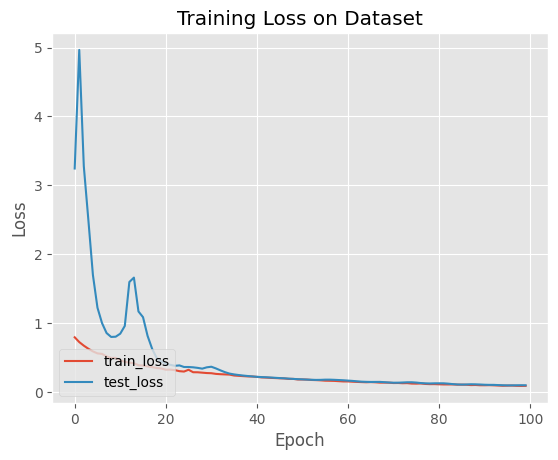

In [25]:
plt.style.use("ggplot")
plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="lower left")


In [54]:
def prepare_plot(PredMask, origMask,pixel_acc, dice, precision, specificity, recall, balanced_accuracy, sensitivity, iou, mean_acc):
    figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
    ax[0].imshow(PredMask)
    ax[0].set_title('Predicted Mask')
    ax[1].imshow(origMask)
    ax[1].set_title('Original Mask')
    print(f" Точность пикселей: {pixel_acc:.2f}, Dice: {dice:.2f}, Точность: {precision:.2f}, Специфичность: {specificity:.2f}, Полнота: {recall:.2f}, Сбалансированная точность: {balanced_accuracy:.2f}, Чувствительность: {sensitivity:.2f}, IoU: {iou:.2f}, Средняя точность: {mean_acc:.2f}")
    figure.show()

 Точность пикселей: 0.97, Dice: 0.66, Точность: 0.97, Специфичность: 1.00, Полнота: 0.50, Сбалансированная точность: 0.75, Чувствительность: 0.50, IoU: 0.49, Средняя точность: 0.50


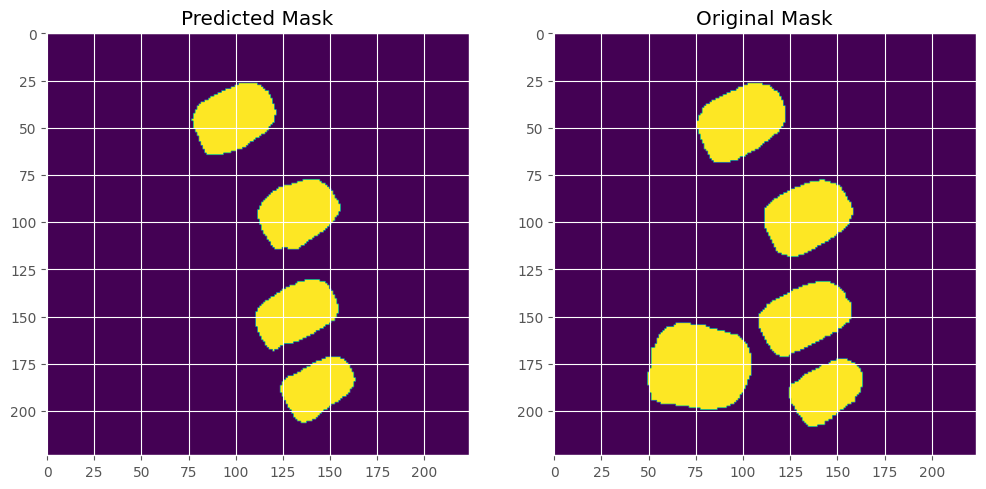

In [55]:
model.eval()
for idx,(x, y) in enumerate(dataloader_valid):

    x = x.to(device)
    y = y.to(device)
    with torch.no_grad():
        preds = torch.sigmoid(model(x))
        preds = (preds >= 0.5).float()
    
        tp = torch.sum(preds * y)  # TP
        fp = torch.sum(preds * (1 - y))  # FP
        fn = torch.sum((1 - preds) * y)  # FN
        tn = torch.sum((1 - preds) * (1 - y))  # TN
        precision = (tp + 1e-8) / (tp + fp + 1e-8)
        recall = (tp + 1e-8) / (tp + fn + 1e-8)
        specificity = (tn  + 1e-8) / (tn + fp + 1e-8)
        sensitivity = (tp + 1e-8) / (tp + fn + 1e-8)
        
        pixel_acc = (tp + tn + 1e-8) / (tp + tn + fp + fn + 1e-8)
        mean_acc = (tp + 1e-8)/(tp+fn + 1e-8)
        balanced_accuracy = (sensitivity + specificity) / 2

        iou = (tp + 1e-8) / (tp + fp + fn + 1e-8)
        dice = (2 * tp + 1e-8) / (2 * tp + fp + fn + 1e-8)

       
    
        prepare_plot(preds[0][0].cpu().detach().numpy(), 
             y[0][0].cpu().detach().numpy(),
                 pixel_acc, dice, precision, specificity, recall, balanced_accuracy, sensitivity, iou, mean_acc
            )